In [2]:
import pandas as pd
import numpy as np

In [3]:
#%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

ModuleNotFoundError: No module named 'tensorflow'

# 1. Leitura de Dados

In [261]:
df = pd.read_csv('../ml_data.csv')
df['data'] = pd.to_datetime(df['data'])
df

data            regional_saude    rt  obitos_por_semana/100k  \
0    2020-04-24  Alto Uruguai Catarinense  2.57                0.000000   
1    2020-04-25  Alto Uruguai Catarinense  2.22                0.000000   
2    2020-04-26  Alto Uruguai Catarinense  2.18                0.000000   
3    2020-04-27  Alto Uruguai Catarinense  2.47                0.000000   
4    2020-04-28  Alto Uruguai Catarinense  2.65                0.000000   
...         ...                       ...   ...                     ...   
6656 2021-06-10                   Xanxerê  1.10                4.475652   
6657 2021-06-11                   Xanxerê  1.11                4.972947   
6658 2021-06-12                   Xanxerê  1.14                4.972947   
6659 2021-06-13                   Xanxerê  1.16                4.475652   
6660 2021-06-14                   Xanxerê  1.14                3.978358   

      casos_por_semana/100k  
0                 15.149115  
1                 14.460519  
2                 24.100866  
3                 42.692962  
4                 51.644712  
...                     ...  
6656             384.408816  
6657             417.727562  
6658             396.841184  
6659             383.414227  
6660             373.468332  

[6661 rows x 5 columns]

## Enriquecimento de Dados

Os dados foram enriquecidos com a informação de feriado.

In [262]:
df_feriados = pd.read_csv('../feriados.csv')
df_feriados['data'] = pd.to_datetime(df_feriados['data'])
df_feriados['feriado'] = 1
df_feriados.head()

data  dia da Semana  feriado
0 2020-01-01   quarta-feira        1
1 2020-02-24  segunda-feira        1
2 2020-02-25    terça-feira        1
3 2020-10-04    sexta-feira        1
4 2020-04-21    terça-feira        1

In [263]:
df['weekend'] = np.where( df['data'].dt.dayofweek < 5, 0, 1)
df['holiday'] = df.merge(df_feriados[['data','feriado']], how='left', on='data')['feriado'].fillna(0)
df.head()

data            regional_saude    rt  obitos_por_semana/100k  \
0 2020-04-24  Alto Uruguai Catarinense  2.57                     0.0   
1 2020-04-25  Alto Uruguai Catarinense  2.22                     0.0   
2 2020-04-26  Alto Uruguai Catarinense  2.18                     0.0   
3 2020-04-27  Alto Uruguai Catarinense  2.47                     0.0   
4 2020-04-28  Alto Uruguai Catarinense  2.65                     0.0   

   casos_por_semana/100k  weekend  holiday  
0              15.149115        0      0.0  
1              14.460519        1      0.0  
2              24.100866        1      0.0  
3              42.692962        0      0.0  
4              51.644712        0      0.0

# Configurações Gerais de Análise

In [264]:
# Número de dias no inicio da séries que serão removidos
n_remove_firsts = 10
# Número de dias do passado que serão usados para predição em uma instância
n_lag = 14
# Núemro de dias do futuro que serãopreditos
n_seq = 5
# Número de instâncias de teste
n_test = 40

# Sobre os dados
# Features numéricas
input_numeric_features = ['rt','obitos_por_semana/100k','casos_por_semana/100k','weekend','holiday']
# Features categóricas (não inclui as binárias)
input_categorical_features = ['regional_saude']
# Feature que define grupos de séries
group_name = 'regional_saude'
# Objetivo preditivos (y)
output_features = ['rt']

# 2. Pré-processamento

## Remoção das N primeiras instâncias de cada série

In [265]:
df = df.groupby(group_name).apply(lambda x : x.tail(len(x)-n_remove_firsts)).reset_index(drop=True)
df.head()

data            regional_saude    rt  obitos_por_semana/100k  \
0 2020-05-04  Alto Uruguai Catarinense  1.98                0.688596   
1 2020-05-05  Alto Uruguai Catarinense  1.73                1.377192   
2 2020-05-06  Alto Uruguai Catarinense  1.57                1.377192   
3 2020-05-07  Alto Uruguai Catarinense  1.45                0.688596   
4 2020-05-08  Alto Uruguai Catarinense  1.34                0.688596   

   casos_por_semana/100k  weekend  holiday  
0              81.942943        0      0.0  
1              81.942943        0      0.0  
2              94.337674        0      0.0  
3              95.026270        0      0.0  
4              89.517501        0      0.0

In [266]:
# Método da primeira diferença (é uma possibilidade mas não estamos usando no momento)
# df[input_numeric_features] = df.groupby(group_name)[input_numeric_features].diff()
# df = df.dropna()
# df

## Encoding and Scalers Features

Os dicionários abaixo são utilizados para armazenar encoders para features categóricas e scalers para as features numéricas. Eles serão utilizados para conhecer a distribuição dos valores das variáveis e poder transformar, posteriormente, novas instâncias para o formato adequado de entrada à rede neural.

In [267]:
encoder_dict = {}
scaler_dict = {}

In [268]:
data = pd.DataFrame()

# Normalização de featues numéricas com MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
for feature_name in input_numeric_features:
  scaler = MinMaxScaler(feature_range=(0,1))
  scaler.fit(df[[feature_name]])
  df_encoded = pd.DataFrame(
         scaler.transform(df[[feature_name]]),
         columns=[feature_name]
     )
  data = pd.concat([data, df_encoded], axis=1)  
  scaler_dict[feature_name] = scaler

# Encoding categorical features com OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
for feature_name in input_categorical_features:
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit(df[[feature_name]])
    df_encoded = pd.DataFrame(
         encoder.transform(df[[feature_name]]),
         columns=encoder.get_feature_names([feature_name])
     )
    data = pd.concat([data, df_encoded], axis=1)    
    encoder_dict[feature_name] = encoder

# Definindo a data como índice do dataframe
data = data.reset_index(drop=True)
data['data'] = df['data']
data[group_name] = df[group_name]
data = data.set_index('data')

data.head()

rt  obitos_por_semana/100k  casos_por_semana/100k  weekend  \
data                                                                           
2020-05-04  0.523669                0.033454               0.057136      0.0   
2020-05-05  0.449704                0.052879               0.057136      0.0   
2020-05-06  0.402367                0.052879               0.065742      0.0   
2020-05-07  0.366864                0.033454               0.066221      0.0   
2020-05-08  0.334320                0.033454               0.062396      0.0   

            holiday  regional_saude_Alto Uruguai Catarinense  \
data                                                           
2020-05-04      0.0                                      1.0   
2020-05-05      0.0                                      1.0   
2020-05-06      0.0                                      1.0   
2020-05-07      0.0                                      1.0   
2020-05-08      0.0                                      1.0   

            regional_saude_Alto Vale do Itajaí  \
data                                             
2020-05-04                                 0.0   
2020-05-05                                 0.0   
2020-05-06                                 0.0   
2020-05-07                                 0.0   
2020-05-08                                 0.0   

            regional_saude_Alto Vale do Rio do Peixe  \
data                                                   
2020-05-04                                       0.0   
2020-05-05                                       0.0   
2020-05-06                                       0.0   
2020-05-07                                       0.0   
2020-05-08                                       0.0   

            regional_saude_Carbonífera  regional_saude_Extremo Oeste  ...  \
data                                                                  ...   
2020-05-04                         0.0                           0.0  ...   
2020-05-05                         0.0                           0.0  ...   
2020-05-06                         0.0                           0.0  ...   
2020-05-07                         0.0                           0.0  ...   
2020-05-08                         0.0                           0.0  ...   

            regional_saude_Grande Florianópolis  regional_saude_Laguna  \
data                                                                     
2020-05-04                                  0.0                    0.0   
2020-05-05                                  0.0                    0.0   
2020-05-06                                  0.0                    0.0   
2020-05-07                                  0.0                    0.0   
2020-05-08                                  0.0                    0.0   

            regional_saude_Meio Oeste  regional_saude_Médio Vale do Itajaí  \
data                                                                         
2020-05-04                        0.0                                  0.0   
2020-05-05                        0.0                                  0.0   
2020-05-06                        0.0                                  0.0   
2020-05-07                        0.0                                  0.0   
2020-05-08                        0.0                                  0.0   

            regional_saude_Nordeste  regional_saude_Oeste  \
data                                                        
2020-05-04                      0.0                   0.0   
2020-05-05                      0.0                   0.0   
2020-05-06                      0.0                   0.0   
2020-05-07                      0.0                   0.0   
2020-05-08                      0.0                   0.0   

            regional_saude_Planalto Norte  regional_saude_Serra Catarinense  \
data                                                                          
2020-05-04                            0.0                               

# 3. Definição dos Conjuntos de Dados de Treinamento e Teste

Neste experimento foi realizada uma divisão em treinamento e teste. O treinamento tem a utilizade de ajustar o modelo preditivo aos dados, mas a acurácia alcançada com os dados de treinamento é naturalmente supertimada, já que o modelo aprendeu com esses dados. Já o conjunto de teste é útil para escolher quando o treinamento deve parar, bem como para avaliar o modelo preditivo.

> Uma análise mais correta seria dividir o conjunto em 3 partes, treinamento, validação e teste. O treinamento para ajustar o modelo aos dados, o de validação para definir o momento de parar o processo de treinamento e escolher um bom modelo, e o terceiro para avaliar o modelo escolhido. Trabalhos futuros.

In [269]:
from sklearn.model_selection import train_test_split

X_train = pd.DataFrame()
y_train = pd.DataFrame()
X_test = pd.DataFrame()
y_test = pd.DataFrame()

for group in data[group_name].unique():

  df_group = data[data[group_name] == group]
  
  X_ = pd.DataFrame()
  X_[group_name] = df_group[group_name]
  
  for feature_name in data.columns[:-1]:
    for i in range(n_lag-1,-1,-1):    
      feature_name_new = feature_name + '_t-'+ str(i)
      X_[feature_name_new] = df_group[feature_name].shift(i)  
    
  # Target
  y_ = pd.DataFrame()
  y_[group_name] = df_group[group_name]  
  for feature_name in output_features:
    for i in range(1,n_seq+1,1):    
      y_[feature_name + '_t+'+ str(i)] = df_group[feature_name].shift(-i)  
    
  # Remover linhas em que X tem NA
  index_X_na = X_.isna().any(axis=1)
  X_ = X_[~index_X_na] 
  y_ = y_[~index_X_na] 
  # Remover linhas em que y tem NA
  index_y_na = y_.isna().any(axis=1)
  X_ = X_[~index_y_na] 
  y_ = y_[~index_y_na]   
      
  # Separação em treino e teste, sem usar o lag do teste como seq do treino
  # por isso o uso de duas divisões de train_test_split
  X_train_, X_aux_, y_train_, y_aux_ = train_test_split(X_, y_, test_size= n_lag + n_test, shuffle=False)
  _ , X_test_, _ , y_test_ = train_test_split(X_aux_, y_aux_, test_size= n_test, shuffle=False)

  X_train = pd.concat([X_train, X_train_], axis=0)
  X_test = pd.concat([X_test, X_test_], axis=0)

  y_train = pd.concat([y_train, y_train_], axis=0)
  y_test = pd.concat([y_test, y_test_], axis=0)

Os conjuntos de dados de treino e teste são dividos em X e y. O objetivo aqui é construir uma função $f(X)$ que estime o valor verdadeiro de $y$, que é o nosso objetivo. Costuma-se chamar essa estimativa de $y_{hat}$ ou $\hat{y}$. Em outra palavras um modelo é um função $f(X) = \hat{y}$, em que $\hat{y}$ tem que ser o mais próximo possível de $y$.

Entendendo as dimensões dos dados de treinamento e teste, para X e y.

- A dimensão D1 no treino (4561) indica que temos 4561 instâncias do problema para treinamento.
- A dimensão D2 no treino em X (295) indica que temos 294 atributos do passado para realizar a predição. Uma dimensão é para a regional de saúde em formato texto.
- A dimensão D2 no treino em y (6) indica que temos 5 valores a serem preditos no futuro. Uma dimensão é para a regional de saúde em formato texto.

- A dimensão D1 no teste (480) indica que temos 480 (30 dias de teste * 16 regiões de saúde) instâncias do problema para teste.
- A dimensão D2 para X e y segue mesma ideia anterior.

In [270]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(5349, 295) (5349, 6)
(640, 295) (640, 6)


In [271]:
X_train.tail(2)

regional_saude   rt_t-13   rt_t-12   rt_t-11   rt_t-10    rt_t-9  \
data                                                                          
2021-04-15        Xanxerê  0.198225  0.186391  0.174556  0.162722  0.156805   
2021-04-16        Xanxerê  0.186391  0.174556  0.162722  0.156805  0.156805   

              rt_t-8    rt_t-7    rt_t-6    rt_t-5  ...  \
data                                                ...   
2021-04-15  0.156805  0.165680  0.174556  0.189349  ...   
2021-04-16  0.165680  0.174556  0.189349  0.201183  ...   

            regional_saude_Xanxerê_t-9  regional_saude_Xanxerê_t-8  \
data                                                                 
2021-04-15                         1.0                         1.0   
2021-04-16                         1.0                         1.0   

            regional_saude_Xanxerê_t-7  regional_saude_Xanxerê_t-6  \
data                                                                 
2021-04-15                         1.0                         1.0   
2021-04-16                         1.0                         1.0   

            regional_saude_Xanxerê_t-5  regional_saude_Xanxerê_t-4  \
data                                                                 
2021-04-15                         1.0                         1.0   
2021-04-16                         1.0                         1.0   

            regional_saude_Xanxerê_t-3  regional_saude_Xanxerê_t-2  \
data                                                                 
2021-04-15                         1.0                         1.0   
2021-04-16                         1.0                         1.0   

            regional_saude_Xanxerê_t-1  regional_saude_Xanxerê_t-0  
data                                                                
2021-04-15                         1.0                         1.0  
2021-04-16                         1.0                         1.0  

[2 rows x 295 columns]

In [272]:
y_train.tail(2)

regional_saude    rt_t+1    rt_t+2    rt_t+3    rt_t+4    rt_t+5
data                                                                       
2021-04-15        Xanxerê  0.263314  0.269231  0.278107  0.269231  0.260355
2021-04-16        Xanxerê  0.269231  0.278107  0.269231  0.260355  0.254438

As dimensões apresentadas anteriormente são aqui transformadas para outro formato.

In [273]:
import numpy as np

def transform_input_to_numpy(data, n_lag):  
  n_samples, n_dim = data.shape
  n_features = n_dim // n_lag 
  c = data.to_numpy().reshape((n_samples, n_features, n_lag))
  c = c.transpose((0,2,1))
  return c

def transform_output_to_numpy(data, n_seq):
  n_features = len(output_features) * n_seq
  c = data.to_numpy()[:,:n_features].reshape((len(data),len(output_features),n_seq))    
  c = c.reshape((c.shape[0],c.shape[2],c.shape[1]))
  return c 

In [274]:
X_train_np = transform_input_to_numpy(X_train.drop(group_name, axis=1), n_lag)
X_test_np = transform_input_to_numpy(X_test.drop(group_name, axis=1), n_lag)

y_train_np = transform_output_to_numpy(y_train.drop(group_name, axis=1), n_seq)
y_test_np = transform_output_to_numpy(y_test.drop(group_name, axis=1), n_seq)

Os dados a seguir estão no formato certo para a entrada de uma rede neural convolucional, em que:
- A dimensão D1 indica o número de instâncias
- A dimensão D2 indica o número de dados do passado (`n_lag`) considerado
- A dimensão D3 indica o número de features de cada momento do passado, isto é 21, que correspondem a 5 features numéricas e 16 regiões de saúde que foram transformados para binário (one hot encoding).

In [275]:
print('X_train_np', X_train_np.shape)
print('X_test_np ', X_test_np .shape)
print('y_train_np', y_train_np.shape)
print('y_test_np ', y_test_np .shape)

X_train_np (5349, 14, 21)
X_test_np  (640, 14, 21)
y_train_np (5349, 5, 1)
y_test_np  (640, 5, 1)


# 4. Definição do Modelo

O modelo preditivo consiste em uma Rede Neural Recorrente (RNN) to tipo Multivariate Sequence To Univariate Sequence.

## Estrutura do Modelo

In [276]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers.wrappers import Bidirectional
from math import sqrt
from matplotlib import pyplot
from tqdm.notebook import tqdm

In [5]:
n_input_features = X_train_np.shape[2]
n_output_featrues =  y_train_np.shape[2]
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='relu', input_shape=( n_lag, n_input_features ))))
model.add(Dropout(0.5))
model.add(RepeatVector( n_seq ))
#model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True)))
#model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense( n_output_featrues, activation='relu')))
opt = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
model.compile(loss='mean_squared_error', optimizer=opt)

NameError: name 'X_train_np' is not defined

## Treinamento do Modelo

In [322]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("keras_model.h5", monitor='val_loss', save_best_only=True)
history = model.fit(X_train_np, y_train_np, epochs=40, verbose=1, batch_size=16, validation_data=(X_test_np, y_test_np), callbacks = [checkpoint])

Epoch 1/20
335/335 [==============================] - 25s 42ms/step - loss: 0.0166 - val_loss: 0.0012
Epoch 2/20
335/335 [==============================] - 12s 37ms/step - loss: 0.0070 - val_loss: 0.0015
Epoch 3/20
335/335 [==============================] - 13s 40ms/step - loss: 0.0057 - val_loss: 0.0011
Epoch 4/20
335/335 [==============================] - 12s 36ms/step - loss: 0.0050 - val_loss: 8.6291e-04
Epoch 5/20
335/335 [==============================] - 12s 36ms/step - loss: 0.0041 - val_loss: 9.5280e-04
Epoch 6/20
335/335 [==============================] - 12s 35ms/step - loss: 0.0037 - val_loss: 0.0010
Epoch 7/20
335/335 [==============================] - 12s 36ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 8/20
335/335 [==============================] - 12s 35ms/step - loss: 0.0029 - val_loss: 8.9809e-04
Epoch 9/20
335/335 [==============================] - 12s 36ms/step - loss: 0.0032 - val_loss: 6.0195e-04
Epoch 10/20
335/335 [==============================] - 12s 36ms/st

In [323]:
from keras.models import load_model
model = load_model("keras_model.h5")

### Fine tuning model


from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)

checkpoint = ModelCheckpoint("keras_model_finetuning.h5", monitor='val_loss', save_best_only=True)
history = model.fit(X_train_np, y_train_np, epochs=20, verbose=1, batch_size=8, validation_data=(X_test_np, y_test_np), callbacks = [checkpoint])

model = load_model("keras_model_finetuning.h5")

# 5. Avaliação do Modelo Preditivo

In [324]:
n_batch = 32

y_train_pred = model.predict(X_train_np, batch_size=n_batch)
y_test_pred = model.predict(X_test_np, batch_size=n_batch)

print('y_train_pred shape: ', y_train_pred.shape )
print('y_test_pred  shape: ', y_test_pred.shape  )

y_train_pred shape:  (5349, 5, 1)
y_test_pred  shape:  (640, 5, 1)


In [325]:
y_train_pred = y_train_pred.squeeze()
y_test_pred  = y_test_pred .squeeze()

print('y_train_pred shape: ', y_train_pred.shape )
print('y_test_pred  shape: ', y_test_pred.shape  )

y_train_pred shape:  (5349, 5)
y_test_pred  shape:  (640, 5)


In [326]:
import scipy.stats

def evaluate_forecasts(test, forecasts, n_seq):
	df_eval = pd.DataFrame()
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		mae = mean_squared_error(actual, predicted)
		rmse = sqrt(mae)		
		corr, _ = scipy.stats.pearsonr(actual, predicted)
		df_eval = df_eval.append({
			'H' : 't+' + str(i + 1),
			't+' : (int) (i + 1),		
			'MAE' : mae,
			'RMSE' : rmse,
			'CORR' : corr
		},ignore_index=True)		
	return df_eval[['H','t+','MAE','RMSE','CORR']]

## Avaliação no Conjunto de Treinamento

In [327]:
evaluate_forecasts(y_train_np.squeeze(), y_train_pred, n_seq)

H   t+       MAE      RMSE      CORR
0  t+1  1.0  0.000665  0.025788  0.955283
1  t+2  2.0  0.000875  0.029586  0.935073
2  t+3  3.0  0.001390  0.037281  0.886349
3  t+4  4.0  0.002041  0.045178  0.820800
4  t+5  5.0  0.002708  0.052035  0.748307

## Avaliação no Conjunto de Teste

In [328]:
evaluate_forecasts(y_test_np.squeeze(), y_test_pred, n_seq)

H   t+       MAE      RMSE      CORR
0  t+1  1.0  0.000230  0.015159  0.850263
1  t+2  2.0  0.000266  0.016309  0.819943
2  t+3  3.0  0.000347  0.018618  0.746663
3  t+4  4.0  0.000468  0.021624  0.630609
4  t+5  5.0  0.000597  0.024425  0.494754

## Plot True vs Predicted

In [329]:
import plotly.express as px

def plot_true_vs_predicted(test, forecasts, n_seq):    
	df_plot = pd.DataFrame()
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		df_plot_ = pd.DataFrame({
			'H' : 't+' + str(i + 1),
			't+' : (int) (i + 1),	
			'True' : actual,
			'Predicted' : predicted,
            'Error' : [ (a-p) for a, p in zip(actual, predicted)]
        })        
		df_plot = df_plot.append(df_plot_, ignore_index=True)
	
	fig = px.scatter(df_plot, x="True", y="Predicted", facet_col="H", facet_col_wrap=4, width=1500, height=550)
	fig.update_layout(margin=dict(l=0, r=0, t=20, b=0) )
	fig.update_yaxes(scaleanchor = "x", scaleratio = 1, range=[0,1])
	fig.update_xaxes(range=[0,1])
	fig.update_traces(marker=dict(size=3))  
	return fig

In [330]:
plot_true_vs_predicted(y_train_np.squeeze(), y_train_pred, n_seq)

In [331]:
plot_true_vs_predicted(y_test_np.squeeze(), y_test_pred, n_seq)

In [332]:
def plot_error_distribution(test, forecasts, n_seq):    
	df_plot = pd.DataFrame()
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		df_plot_ = pd.DataFrame({
			'H' : 't+' + str(i + 1),
			't+' : (int) (i + 1),	
			'True' : actual,
			'Predicted' : predicted,
            'Error (true-pred)' : [ (a-p) for a, p in zip(actual, predicted)]
        })        
		df_plot = df_plot.append(df_plot_, ignore_index=True)	
	fig = px.histogram(df_plot, x="Error (true-pred)", facet_col="H", facet_col_wrap=4, width=1500, height=550)    
	fig.add_vline(x=-0, line_width=1, line_dash="dash")
	fig.update_layout(margin=dict(l=0, r=0, t=20, b=0) )
	return fig

## Plot da Distribuição dos Erros

In [333]:
plot_error_distribution(y_train_np.squeeze(), y_train_pred, n_seq)

In [334]:
plot_error_distribution(y_test_np.squeeze(), y_test_pred, n_seq)

# Predições denormalizadas

In [335]:
y_train_pred_ = y_train.copy()
y_test_ = y_test.copy()
y_test_pred_ = y_test.copy()
y_train_ = y_train.copy()

y_test_pred_[y_test.columns[1:]] = y_test_pred
y_train_pred_[y_train.columns[1:]] = y_train_pred

In [336]:
# Inverse transform

for colname in y_test.columns[1:]:
  y_test_[[colname]] = scaler_dict[output_features[0]].inverse_transform(y_test_[[colname]])

for colname in y_train.columns[1:]:
  y_train_[[colname]] = scaler_dict[output_features[0]].inverse_transform(y_train_[[colname]])

for colname in y_test.columns[1:]:
  y_test_pred_[[colname]] = scaler_dict[output_features[0]].inverse_transform(y_test_pred_[[colname]])

for colname in y_train.columns[1:]:
  y_train_pred_[[colname]] = scaler_dict[output_features[0]].inverse_transform(y_train_pred_[[colname]])

print(y_test_.head())
print(y_test_pred_.head())
print(y_train_.head())
print(y_train_pred_.head())


                      regional_saude  rt_t+1  rt_t+2  rt_t+3  rt_t+4  rt_t+5
data                                                                        
2021-05-01  Alto Uruguai Catarinense    1.11    1.14    1.15    1.15    1.12
2021-05-02  Alto Uruguai Catarinense    1.14    1.15    1.15    1.12    1.10
2021-05-03  Alto Uruguai Catarinense    1.15    1.15    1.12    1.10    1.09
2021-05-04  Alto Uruguai Catarinense    1.15    1.12    1.10    1.09    1.05
2021-05-05  Alto Uruguai Catarinense    1.12    1.10    1.09    1.05    1.03
                      regional_saude    rt_t+1    rt_t+2    rt_t+3    rt_t+4  \
data                                                                           
2021-05-01  Alto Uruguai Catarinense  1.112201  1.109801  1.103641  1.095804   
2021-05-02  Alto Uruguai Catarinense  1.117490  1.112257  1.103075  1.092446   
2021-05-03  Alto Uruguai Catarinense  1.118684  1.108977  1.095780  1.082046   
2021-05-04  Alto Uruguai Catarinense  1.109278  1.097120  1.0

In [337]:
import numpy as np, scipy.stats as st

def confIntMean(a, conf=0.95):
  mean, sem, m = np.mean(a), st.sem(a), st.t.ppf((1+conf)/2., len(a)-1)
  return mean - m*sem, mean + m*sem

from scipy import stats
def evaluate_forecasts_df(df_actual, df_forecasts, n_seq):
	df_eval = pd.DataFrame()
	for i in range(n_seq):
		actual = df_actual[output_features[0]+'_t+'+str(i+1)].values
		predicted = df_forecasts[output_features[0]+'_t+'+str(i+1)].values
		mae = mean_squared_error(actual, predicted)
		rmse = sqrt(mae)		
		corr, _ = scipy.stats.pearsonr(actual, predicted)
		diff = actual - predicted
		df_eval = df_eval.append({
			'H' : 't+' + str(i + 1),
			't+' : (int) (i + 1),		
			'MAE' : mae,
			'RMSE' : rmse,
			'CORR' : corr,
            'error_mean' : np.mean(diff),
            'error_std' : np.std(diff),
        },ignore_index=True)		
	return df_eval[['H','t+','MAE','RMSE','CORR','error_mean','error_std']]

In [338]:
evaluate_forecasts_df(y_train_, y_train_pred_, n_seq)

H   t+       MAE      RMSE      CORR  error_mean  error_std
0  t+1  1.0  0.007597  0.087162  0.955283    0.008207   0.086775
1  t+2  2.0  0.010000  0.100002  0.935073    0.010703   0.099428
2  t+3  3.0  0.015879  0.126011  0.886349    0.012687   0.125371
3  t+4  4.0  0.023318  0.152703  0.820800    0.014203   0.152041
4  t+5  5.0  0.030934  0.175879  0.748307    0.015046   0.175235

In [339]:
y_test_pred_stats = evaluate_forecasts_df(y_test_, y_test_pred_, n_seq)
y_test_pred_stats.to_csv('model/df_y_pred_stats.csv', index=False)
y_test_pred_stats

H   t+       MAE      RMSE      CORR  error_mean  error_std
0  t+1  1.0  0.002625  0.051239  0.850263    0.016914   0.048367
1  t+2  2.0  0.003039  0.055123  0.819943    0.017036   0.052424
2  t+3  3.0  0.003960  0.062929  0.746663    0.016489   0.060730
3  t+4  4.0  0.005342  0.073090  0.630609    0.015075   0.071518
4  t+5  5.0  0.006815  0.082555  0.494754    0.011680   0.081725

## Visualizações de Predições

<module 'matplotlib.pyplot' from 'd:\\Users\\andres\\git_projects\\prodin-covid19\\env\\lib\\site-packages\\matplotlib\\pyplot.py'>

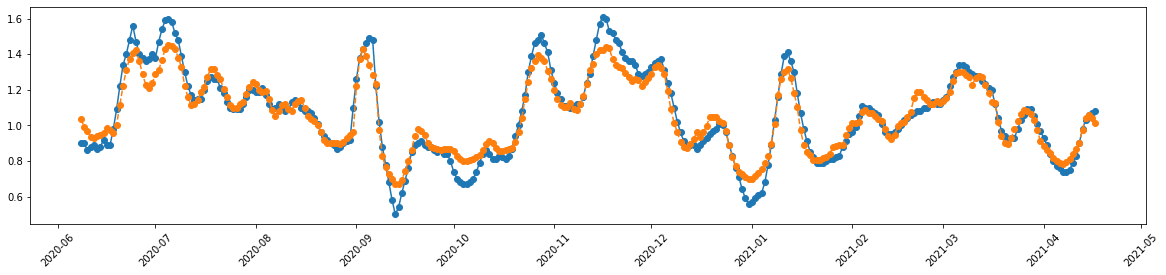

In [340]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
import datetime

def plot_1 (df, y_true, y_pred, group_name, group, target, h=1, last = 10):
  all = df[df[group_name] == group][[target]]
  all[[target]] = scaler_dict[target].inverse_transform( all[[target]] )
  target_h = target+'_t+'+str(h)
  true = y_true[y_true[group_name] == group][[target_h]]  
  pred = y_pred[y_pred[group_name] == group][[target_h]]
  # prepare plot
  pred.index = [time + datetime.timedelta(h) for time in pred.index]
  true.index = [time + datetime.timedelta(h) for time in true.index]
  range_pred = [ pred.index[0], pred.index[-1] ]
  range_x = pd.date_range( start=pred.index[0] - datetime.timedelta(last), end=pred.index[-1]).tolist()  
  plt.rcParams["figure.figsize"] = (20,4)
  #plt.plot(all.loc[range_x,:], '-o')    
  plt.plot(true, '-o')    
  plt.plot(pred, '--o')  
  plt.xticks(rotation=45)
  return plt

plot_1(df, y_train_, y_train_pred_, group_name, 'Alto Vale do Itajaí', output_features[0], 1)

<module 'matplotlib.pyplot' from 'd:\\Users\\andres\\git_projects\\prodin-covid19\\env\\lib\\site-packages\\matplotlib\\pyplot.py'>

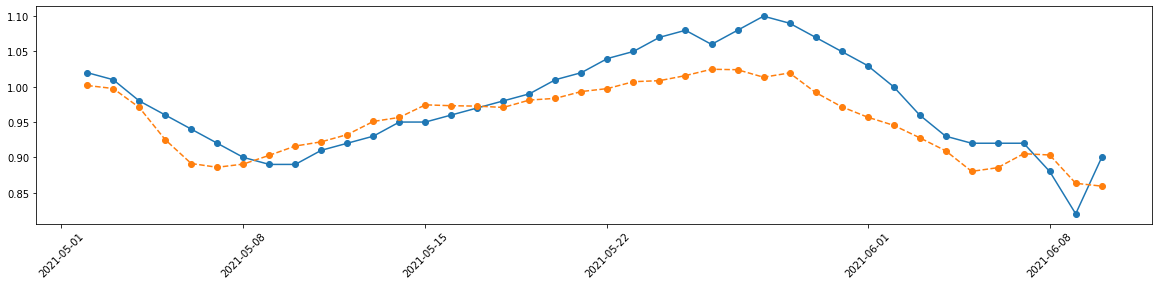

In [341]:
plot_1(df, y_test_, y_test_pred_, group_name, 'Alto Vale do Itajaí', output_features[0], 1, 30)

regional_saude  rt_t+1  rt_t+2  rt_t+3
data                                                        
2020-05-18  Alto Uruguai Catarinense    1.24    1.34    1.27
2020-05-19  Alto Uruguai Catarinense    1.34    1.27    1.34
2020-05-20  Alto Uruguai Catarinense    1.27    1.34    1.39
2020-05-21  Alto Uruguai Catarinense    1.34    1.39    1.46
2020-05-22  Alto Uruguai Catarinense    1.39    1.46    1.50
...                              ...     ...     ...     ...
2021-02-22                   Xanxerê    1.41    1.36    1.30
2021-02-23                   Xanxerê    1.36    1.30    1.25
2021-02-24                   Xanxerê    1.30    1.25    1.20
2021-02-25                   Xanxerê    1.25    1.20    1.17
2021-02-26                   Xanxerê    1.20    1.17    1.14

[4593 rows x 4 columns]

In [342]:
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

def plot_2 (df, y_true, y_pred, group_name, group, target, stats, h=1, last = 10):
    all = df[df[group_name] == group][[target]]    
    target_h = target+'_t+'+str(h)
    true = y_true[y_true[group_name] == group][[target_h]]  
    pred = y_pred[y_pred[group_name] == group][[target_h]]
    
    pred.index = [time + datetime.timedelta(h) for time in pred.index]
    true.index = [time + datetime.timedelta(h) for time in true.index]
    range_pred = [ pred.index[0], pred.index[-1] ]
    range_x = pd.date_range( start=pred.index[0] - datetime.timedelta(last), end=pred.index[-1]).tolist()      
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            name=group+"_"+target,
            x=range_x,
            mode='lines+markers',
            y=all.loc[range_x,:].values.squeeze()            
        )
    )
    std = stats['error_std'][h-1]
    ci_inf = pred.values.squeeze() - 1.96 * std
    ci_sup = pred.values.squeeze() + 1.96 * std
    print()
    fig.add_trace(
        go.Scatter(
            name=group+"_"+target_h+"_pred",
            x=pred.index,
            y=pred.values.squeeze(),            
            mode='lines+markers',
            line={'dash': 'dash', 'color': 'green'}
        )
    )

    fig.add_trace(
        go.Scatter(
            name='IC Inferior',
            x=pred.index,
            y=ci_inf,
            showlegend=False,
            line=dict(width=0),       
        )
    )

    fig.add_trace(
        go.Scatter(
            name='IC Superior',
            x=pred.index,
            y=ci_sup,
            fillcolor='rgba(68, 68, 68, 0.2)',
            fill='tonexty',
            showlegend=False,
            line=dict(width=0),
        )
    )
    fig.update_layout(width = 1200, height = 400)          


    return fig

plot_2(df.set_index('data'), y_test_, y_test_pred_, group_name, 'Alto Vale do Itajaí', output_features[0], y_test_pred_stats, 1, 20 )

In [343]:
def plot_3 (df, y_true, y_pred, y_pred_index, group_name, group, target, stats, n_seq, last = 10):
    all = df[df[group_name] == group][[target]]
    y_pred = y_pred[y_pred[group_name] == group].iloc[[y_pred_index],:]
    range_x = pd.date_range( start=y_pred.index[0] - datetime.timedelta(last), end=y_pred.index[0] + datetime.timedelta(n_seq)).tolist()    
    values_x_pred = pd.date_range( start=y_pred.index[0] + datetime.timedelta(1), end=y_pred.index[0] + datetime.timedelta(n_seq) ).tolist()    
    values_y_pred = y_pred[y_pred.columns[1:]].values[0] 
    
    df_values_pred = pd.DataFrame({
        'y_pred' : values_y_pred,
        'error_std' : stats['error_std'].values
        },
        index = values_x_pred )
    df_values_pred['ci_min'] = df_values_pred['y_pred'] - 1.96 * df_values_pred['error_std']
    df_values_pred['ci_max'] = df_values_pred['y_pred'] + 1.96 * df_values_pred['error_std']

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            name=group+"_"+target,
            x=range_x,
            mode='lines+markers',
            y=all.loc[range_x,:].values.squeeze()            
        )
    )

    fig.add_trace(
        go.Scatter(
            name=group+"_"+target+"_pred",
            x=df_values_pred.index,
            y=df_values_pred['y_pred'],            
            mode='lines+markers',
            line={'dash': 'dash', 'color': 'green'}
        )
    )

    fig.add_trace(
        go.Scatter(
            name='IC Inferior',
            x=df_values_pred.index,
            y=df_values_pred['ci_min'],   
            showlegend=False,
            mode='lines',
            line=dict(width=0),       
        )
    )

    fig.add_trace(
        go.Scatter(
            name='IC Superior',            
            x=df_values_pred.index,
            y=df_values_pred['ci_max'],   
            fillcolor='rgba(68, 68, 68, 0.2)',
            fill='tonexty',
            mode='lines',
            showlegend=False,
            line=dict(width=0),
        )
    )
    
    fig.update_layout(width = 1200, height = 400)          

    return fig

plot_3(df.set_index('data'), y_test_, y_test_pred_,-4, group_name, 'Xanxerê', output_features[0], y_test_pred_stats, n_seq, 60 )

## Saving Model, Scalers, and Encoders

In [344]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


In [345]:
import pickle 
filehandler = open("model/scalers.dict", 'wb') 
pickle.dump(scaler_dict, filehandler)
filehandler.close()

filehandler = open("model/encoders.dict", 'wb') 
pickle.dump(encoder_dict, filehandler)
filehandler.close()

In [346]:
P_df = pd.read_csv('../ml_data.csv')
#P_df['data'] = pd.to_datetime(P_df['data'])
#P_df = P_df[P_df[group_name] == 'Alto Uruguai Catarinense']
#P_df['weekend'] = np.where( P_df['data'].dt.dayofweek < 5, 0, 1)
P_df.tail(14)

data regional_saude    rt  obitos_por_semana/100k  \
6647  2021-06-01        Xanxerê  0.94                1.989179   
6648  2021-06-02        Xanxerê  0.97                0.497295   
6649  2021-06-03        Xanxerê  1.00                0.497295   
6650  2021-06-04        Xanxerê  1.04                1.989179   
6651  2021-06-05        Xanxerê  1.07                2.486474   
6652  2021-06-06        Xanxerê  1.08                2.983768   
6653  2021-06-07        Xanxerê  1.11                2.486474   
6654  2021-06-08        Xanxerê  1.07                4.475652   
6655  2021-06-09        Xanxerê  1.02                3.978358   
6656  2021-06-10        Xanxerê  1.10                4.475652   
6657  2021-06-11        Xanxerê  1.11                4.972947   
6658  2021-06-12        Xanxerê  1.14                4.972947   
6659  2021-06-13        Xanxerê  1.16                4.475652   
6660  2021-06-14        Xanxerê  1.14                3.978358   

      casos_por_semana/100k  
6647             292.906588  
6648             289.425525  
6649             312.798377  
6650             281.966104  
6651             311.803787  
6652             313.792966  
6653             325.728039  
6654             266.549968  
6655             357.554901  
6656             384.408816  
6657             417.727562  
6658             396.841184  
6659             383.414227  
6660             373.468332

In [347]:
def predict_from_date(model, scaler_dict, encoder_dict, df, date, df_y_pred_stats):
    df['data'] = pd.to_datetime(df['data'])    
    df['weekend'] = np.where( df['data'].dt.dayofweek < 5, 0, 1)
    df['holiday'] = df.merge(df_feriados[['data','feriado']], how='left', on='data')['feriado'].fillna(0)
    range_x = pd.date_range( start=pd.to_datetime(date) - datetime.timedelta(n_lag-1), end=pd.to_datetime(date))
    range_y = pd.date_range( start=pd.to_datetime(date) + datetime.timedelta(1), end=pd.to_datetime(date) + datetime.timedelta(n_seq))
   
    df = df[df['data'].isin(range_x)].copy()
    
    data = pd.DataFrame()
    
    for feature_name in input_numeric_features:               
        df_encoded = pd.DataFrame(
            scaler_dict[feature_name].transform(df[[feature_name]]),
            columns=[feature_name]
        )        
        data = pd.concat([data, df_encoded], axis=1)

    for feature_name in input_categorical_features:
        df_encoded = pd.DataFrame(
            encoder_dict[feature_name].transform(df[[feature_name]]),
            columns=encoder.get_feature_names([feature_name])
        )
        data = pd.concat([data, df_encoded], axis=1)   
    
    group_name = 'regional_saude'    
    data[group_name] = df[group_name].values    
    
    X_ = pd.DataFrame()
    groups = data[group_name].unique()
    for group in groups:
        df_group = data[data[group_name] == group].drop(columns=group_name)              
        values = []    
        for feature_name in df_group.columns:
            values = np.concatenate( (values, df_group[feature_name].values) )
        X_ = X_.append(pd.DataFrame([values]))
    
    X = transform_input_to_numpy(X_, n_lag)
    
    y = model.predict(X).squeeze()
    
    y = scaler_dict[output_features[0]].inverse_transform(y).squeeze()
    
    
    df_y = pd.DataFrame()
    import scipy.stats as st
    IC_95 = st.norm.ppf(.95) * df_y_pred_stats['error_std'].values
    
    for i in range(len(groups)):
        group = groups[i]
        group_pred = y[i]
        df_group = pd.DataFrame({
            group_name : group,
            'data' : range_y,
            'pred' : group_pred,
            'pred_IC_95_inf' : group_pred - IC_95,
            'pred_IC_95_sup' : group_pred + IC_95
            })
        df_y = df_y.append(df_group)
        
    return df_y


a = predict_from_date(model, scaler_dict, encoder_dict, P_df, '2021-06-14', y_test_pred_stats)
np.round(a,2)

regional_saude       data  pred  pred_IC_95_inf  pred_IC_95_sup
0   Alto Uruguai Catarinense 2021-06-15  1.12            1.04            1.20
1   Alto Uruguai Catarinense 2021-06-16  1.11            1.03            1.20
2   Alto Uruguai Catarinense 2021-06-17  1.09            0.99            1.19
3   Alto Uruguai Catarinense 2021-06-18  1.08            0.96            1.19
4   Alto Uruguai Catarinense 2021-06-19  1.06            0.92            1.19
..                       ...        ...   ...             ...             ...
0                    Xanxerê 2021-06-15  1.09            1.02            1.17
1                    Xanxerê 2021-06-16  1.08            0.99            1.16
2                    Xanxerê 2021-06-17  1.06            0.96            1.15
3                    Xanxerê 2021-06-18  1.04            0.92            1.15
4                    Xanxerê 2021-06-19  1.02            0.89            1.16

[80 rows x 5 columns]

In [352]:
encoder.get_feature_names()

array(['x0_Alto Uruguai Catarinense', 'x0_Alto Vale do Itajaí',
       'x0_Alto Vale do Rio do Peixe', 'x0_Carbonífera',
       'x0_Extremo Oeste', 'x0_Extremo Sul Catarinense',
       'x0_Foz do Rio Itajaí', 'x0_Grande Florianópolis', 'x0_Laguna',
       'x0_Meio Oeste', 'x0_Médio Vale do Itajaí', 'x0_Nordeste',
       'x0_Oeste', 'x0_Planalto Norte', 'x0_Serra Catarinense',
       'x0_Xanxerê'], dtype=object)